In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.distributions.dirichlet import Dirichlet
from itertools import permutations

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

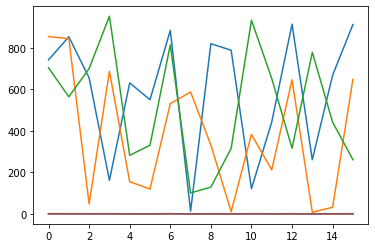

In [2]:
size = 16
asset_length = 3

assets = torch.stack((torch.randint(1, 1000, (size,)), torch.randint(1, 1000, (size,)), torch.randint(1, 1000, (size,)))).to(device)
normalized_assets = (assets.T / assets[:, 0]).T

for asset in assets:
    plt.plot(asset.cpu())

for asset in normalized_assets:
    plt.plot(asset.cpu())

FigureWidget({
    'data': [{'marker': {'color': array([-3.2757566, -3.330398 , -3.3853924, ..., -3.0784633, -…

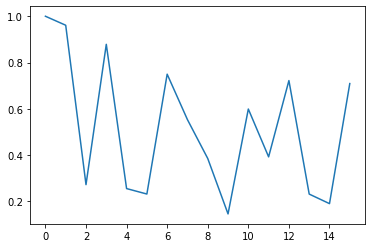

In [3]:
space = torch.stack([torch.Tensor(x)/100 for x in permutations(np.arange(100), 3) if sum(x) == 100])

#Random weights
m = Dirichlet(torch.ones(assets.shape[0]))
weights = m.sample()

#Random portfolio
portfolio = (normalized_assets.T * weights).sum(axis = 1)
plt.plot(portfolio)

def log_return(x):
    return torch.log(x[-1])

def log_of_downside(x):
    x = x[x < 1]
    return torch.nan_to_num(-torch.sum(torch.log(x)))

def gini_t(x):
    x = torch.Tensor(x).flatten()
    if torch.amin(x) < 0:
        x -= torch.amin(x)
    x += 0.0000001
    x, b = torch.sort(x)
    index = torch.arange(1, x.shape[0] + 1)
    n = x.shape[0]
    return ((torch.sum((2 * index - n  - 1) * x)) / (n * torch.sum(x)))

def objective_function(portfolio, weights):
    r, d, g = log_return(portfolio), log_of_downside(portfolio), gini_t(weights)
    #print(r, d, g)
    return (r - d) * (1 - g)

def fitness(assets, weights):
    portfolio = (assets.T * weights).sum(axis = 1)
    score = objective_function(portfolio, weights)
    #print(score)
    return score

F = torch.stack([fitness(normalized_assets, p) for p in space])

space[F.argmax()].round()

F.max()

x, y, z = space[:, 0].numpy(), space[:, 1].numpy(), space[:, 2].numpy()

import plotly.graph_objects as go
import numpy as np

fig = go.FigureWidget(data=[
    go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color= F.numpy(),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8)),
    go.Scatter3d(
    x=[1/3],
    y=[1/3],
    z=[1/3],
    mode='markers',
    marker=dict(
        size=12,
        color= [1],                # set color to an array/list of desired values
        colorscale='Reds',   # choose a colorscale
        opacity=0.8)),
                     ])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [4]:
from portfolio_fitness import fitness

In [5]:
def pop_best(hof_fit, hof_pop, fitness, population, asset_length):
    idx = torch.argmax(fitness)
    hof_fit = torch.cat([hof_fit, fitness[idx].view(-1, 1)])
    hof_pop = torch.cat([hof_pop, population[idx].view(-1, asset_length)])
    return hof_fit, hof_pop

solution_size = asset_length
population_size = 1000
differential_weight = 0.5
gene_probability = 1 - 1/solution_size
rounds = 100
condition = 1000

#crossover_probability = 0.5
#uni_dist = torch.distributions.uniform.Uniform(0, 1)

#Starting population and fitness
m = Dirichlet(torch.ones(solution_size))
population = torch.stack([m.sample() for _ in range(population_size)])
pop_fitness = torch.stack([fitness(normalized_assets, p) for p in population])

#Hall of fame
hof_fit = torch.Tensor([]).view(-1, 1)
hof_pop = torch.Tensor([]).view(-1, solution_size)
hof_fit, hof_pop = pop_best(hof_fit, hof_pop, pop_fitness, population, asset_length)

for i in range(rounds):
    #Trial population
    v1 = population[torch.randperm(population_size)]
    v2 = population[torch.randperm(population_size)]
    v3 = population[torch.randperm(population_size)]
    trial_population = v1 * (1 - differential_weight) + (v2 + v3) / 2 * differential_weight
    
    #Crossover proabability
    #crossover_probabilities = uni_dist.sample(torch.Size([population_size, 1])) < 0.5
    #trial_population = torch.where(crossover_probabilities, population, trial_population)
    trial_pop_fitness = torch.stack([fitness(normalized_assets, p) for p in trial_population])

    #New population and fitness
    population = torch.where((pop_fitness > trial_pop_fitness).view(-1, 1), population, trial_population)
    pop_fitness = torch.stack([fitness(normalized_assets, p) for p in population])
    
    #Append to HOF
    hof_fit, hof_pop = pop_best(hof_fit, hof_pop, pop_fitness, population, asset_length)
    
    #print(pop_fitness.mean(), hof_fit[-1])
    #Stopping condition
    if i > condition:
        if ((hof_fit[-condition:] - hof_fit[-condition-1:-1]) > 1e-5).sum() == 0:
            break
    
    fig.data[1].x = population[:, 0].numpy()
    fig.data[1].y = population[:, 1].numpy()
    fig.data[1].z = population[:, 2].numpy()
    X = F.numpy()
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    fig.data[1]['marker']['color'] = X_std

In [6]:
fig

FigureWidget({
    'data': [{'marker': {'color': array([-3.2757566, -3.330398 , -3.3853924, ..., -3.0784633, -…

In [7]:
def pop_best(hof_fit, hof_pop, fitness, population, asset_length):
    idx = torch.argmax(fitness)
    hof_fit = torch.cat([hof_fit, fitness[idx].view(-1, 1)])
    hof_pop = torch.cat([hof_pop, population[idx].view(-1, asset_length)])
    return hof_fit, hof_pop

solution_size = asset_length
population_size = 1000
differential_weight = 0.5
gene_probability = 1 - 1/solution_size
rounds = 100
condition = 1000

move_amount = 0.25
disturbance_threshold = 0.05
uni_dist = torch.distributions.uniform.Uniform(0, 1)

#Starting population and fitness
m = Dirichlet(torch.ones(solution_size))
population = torch.stack([m.sample() for _ in range(population_size)])
pop_fitness = torch.stack([fitness(normalized_assets, p) for p in population])

#Hall of fame
hof_fit = torch.Tensor([]).view(-1, 1)
hof_pop = torch.Tensor([]).view(-1, solution_size)
hof_fit, hof_pop = pop_best(hof_fit, hof_pop, pop_fitness, population, asset_length)

for i in range(rounds):
    
    #Best case
    swarms_best = population[torch.argmax(pop_fitness)]
    
    #Best neighbour
    best_neighbours = torch.where((pop_fitness > torch.roll(pop_fitness, 1, 0)).view(-1, 1), population, torch.roll(population, 1, 0))
    
    #Update in the direction of best
    population = best_neighbours * (1 - move_amount) + swarms_best * move_amount
    
    #Disturbance and new population
    trial_population = torch.stack([m.sample() for _ in range(population_size)])
    crossover_probabilities = uni_dist.sample(torch.Size([population_size, 1])) > disturbance_threshold
    trial_population = torch.where(crossover_probabilities, population, trial_population)
    population = (population + trial_population) / 2
    pop_fitness = torch.stack([fitness(normalized_assets, p) for p in population])

    #Append to HOF
    hof_fit, hof_pop = pop_best(hof_fit, hof_pop, pop_fitness, population, asset_length)
    
    #print(pop_fitness.mean(), hof_fit[-1])
    #Stopping condition
    if i > condition:
        if ((hof_fit[-condition:] - hof_fit[-condition-1:-1]) > 1e-5).sum() == 0:
            break
            
    fig.data[1].x = population[:, 0].numpy()
    fig.data[1].y = population[:, 1].numpy()
    fig.data[1].z = population[:, 2].numpy()
    X = F.numpy()
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    fig.data[1]['marker']['color'] = X_std